## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !rm -rf ./mae
    !git clone https://github.com/JerryX1110/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 6.8 MB/s eta 0:00:00
Cloning into 'mae'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 81 (delta 23), reused 0 (delta 0), pack-reused 39
Unpacking objects: 100% (81/81), 2.95 MiB | 5.23 MiB/s, done.


MAE with pixel reconstruction:
go on run MAE
masking_strategy center
mask_pix_num 96
ids_keep [  0 154 153 152 141 140 139 138 127 126 125 124 113 112 111 110  99  98
 194  96  85  84  83  82  71  70 155  69 166 168 193 192 191 190 189 188
 187 186 185 184 183 182 181 180 179 178 177 176 175 174 173 172 171 170
 169 167  68  97 195  18  19  20  21  43  23  24  17  25  27  28  57  40
  29  41  42  26  16  22  14   1   2   3  15   5   6   7   8   4  56  55
  13  54  12  10   9  11]


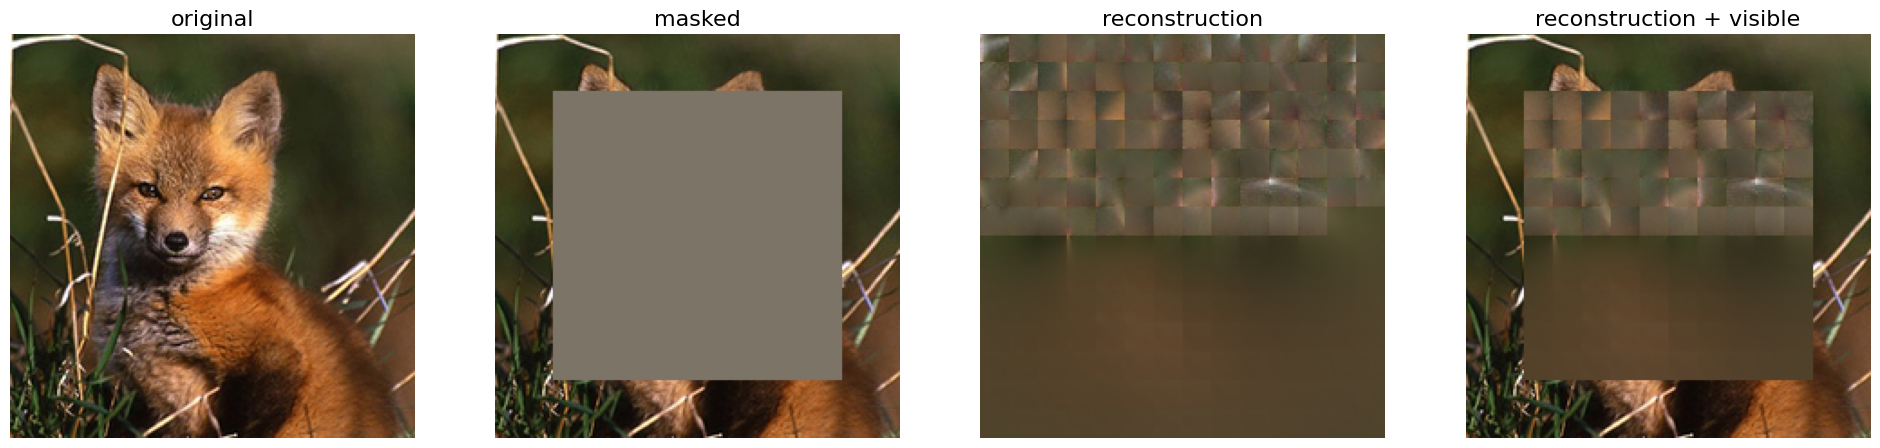

In [8]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
#run_one_image(img, model_mae, mask_ratio=1, masking_strategy='center')
#run_one_image(img, model_mae, mask_ratio=0.5, masking_strategy='random')
#run_one_image(img, model_mae, mask_ratio=0.75, masking_strategy='random')

run_one_image(img, model_mae, mask_ratio=0.4, masking_strategy='center')

### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model, mask_ratio=0.75, masking_strategy='random'):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    print("go on run MAE")
    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=mask_ratio, masking_strategy=masking_strategy)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

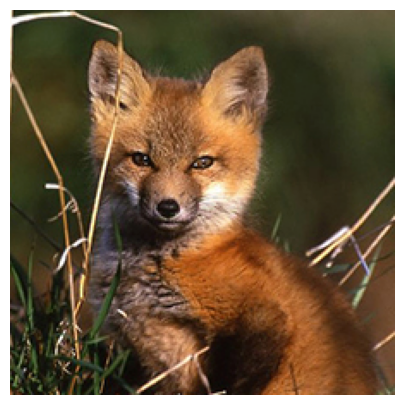

In [3]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [4]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


--2023-04-23 11:52:54--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.85.39, 13.249.85.90, 13.249.85.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.85.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318315181 (1.2G) [binary/octet-stream]
Saving to: ‘mae_visualize_vit_large.pth’

mae_visualize_vit_l 100%[===================>]   1.23G   113MB/s    in 7.9s    

2023-04-23 11:53:02 (159 MB/s) - ‘mae_visualize_vit_large.pth’ saved [1318315181/1318315181]

<All keys matched successfully>
Model loaded.


In [15]:
def gen_center_mask(emb_shape=(4,4), mask_ratio=0.5):
  mask = np.linspace(1,1,emb_shape[0]*emb_shape[1]).reshape(emb_shape)
  quarter_num_x = int(emb_shape[0]*mask_ratio/2)
  quarter_num_y = int(emb_shape[1]*mask_ratio/2)
  mask[0:quarter_num_x,:]=0
  mask[emb_shape[0]-quarter_num_x:,:]=0
  mask[:, 0:quarter_num_x]=0
  mask[:, emb_shape[1]-quarter_num_x:]=0
  mask = mask.flatten()
  ids = np.argsort(mask)
  mask_pix_num = int((1-mask).sum())
  ids_keep = ids[:mask_pix_num]
  return ids, mask, ids_keep

ids, mask, ids_keep = gen_center_mask()
print(ids_keep)

print(mask)
print(ids)

[ 0  1  2  3  4  7  8 11 12 13 14 15]
[0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
[ 0  1  2  3  4  7  8 11 12 13 14 15  5  6  9 10]


In [24]:
 def center_masking(x, mask_ratio):
    """
    Perform per-sample random masking by per-sample shuffling.
    Per-sample shuffling is done by argsort random noise.
    x: [N, L, D], sequence
    """
    N, L, D = x.shape  # batch, length, dim
    patch_size = np.int(np.sqrt(L))
    ids, mask, ids_keep = gen_center_mask((patch_size,patch_size), mask_ratio)
    ids_shuffle = torch.tensor(ids).unsqueeze(0).repeat(N,1)         
    ids_restore = torch.argsort(ids_shuffle, dim=1) #ids_shuffle
    
    mask = torch.tensor(mask).unsqueeze(0).repeat(N,1).to(x.device)

    x_masked = torch.gather(x, dim=1, index=torch.tensor(ids_keep).unsqueeze(-1).repeat(1, 1, D))
    # generate the binary mask: 0 is keep, 1 is remove  
    mask = torch.ones([N, L], device=x.device)
    mask[:, ids_keep] = 0
    mask = torch.gather(mask, dim=1, index=ids_restore)
    return x_masked, mask, ids_restore

 def fix_masking(x, mask_ratio):
    """
    Perform per-sample random masking by per-sample shuffling.
    Per-sample shuffling is done by argsort random noise.
    x: [N, L, D], sequence
    """
    N, L, D = x.shape  # batch, length, dim
    print("mask L", L)
    len_keep = int(L * (1 - mask_ratio))

    patch_size = np.int(np.sqrt(L))
    print(patch_size)
    
    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
    print("noise",noise.size())
    # sort noise for each sample
    ids_shuffle = (torch.tensor(np.int64(np.linspace(0,L-1,L))).unsqueeze(0).repeat(N,1))           #torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    ids_restore = ids_shuffle #torch.argsort(ids_shuffle, dim=1)
    print(ids_shuffle.size())
    print(ids_shuffle)

    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, mask, ids_restore

 def random_masking(x, mask_ratio):
    """
    Perform per-sample random masking by per-sample shuffling.
    Per-sample shuffling is done by argsort random noise.
    x: [N, L, D], sequence
    """
    N, L, D = x.shape  # batch, length, dim
    
    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
    print("noise",noise)
    len_keep = int(L * (1 - mask_ratio))
    
    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    print("ids_shuffle",ids_shuffle)
    ids_restore = torch.argsort(ids_shuffle, dim=1)
    print("ids_restore",ids_restore)
    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    print("ids_keep",ids_keep)
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, mask, ids_restore

def random_masking2(x, mask_ratio):
    """
    Perform per-sample random masking by per-sample shuffling.
    Per-sample shuffling is done by argsort random noise.
    x: [N, L, D], sequence
    """
    N, L, D = x.shape  # batch, length, dim
    
    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
    len_keep = int(L * (1 - mask_ratio))
    
    # sort noise for each sample
    ids_shuffle = (torch.tensor(np.int64(np.linspace(0,L-1,L))).unsqueeze(0).repeat(N,1))           #torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    ids_restore = ids_shuffle 

    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, mask, ids_restore


In [23]:
mask = np.linspace(0,1*16*1 - 1,1*16*1).reshape((1,16,1))
mask_ts = torch.tensor(mask)
print("mask_ts.size()",mask_ts.size())

x_masked, mask, ids_restore = center_masking(mask_ts, 0.75)

print("######output")
print(x_masked)
print(mask)
print(ids_restore)


mask_ts.size() torch.Size([1, 16, 1])
ids_shuffle tensor([[ 0,  1,  2,  3,  4,  7,  8, 11, 12, 13, 14, 15,  5,  6,  9, 10]])
ids_restore tensor([[ 0,  1,  2,  3,  4, 12, 13,  5,  6, 14, 15,  7,  8,  9, 10, 11]])
######output
tensor([[[ 0.],
         [ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 7.],
         [ 8.],
         [11.],
         [12.],
         [13.],
         [14.],
         [15.]]], dtype=torch.float64)
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.]])
tensor([[ 0,  1,  2,  3,  4, 12, 13,  5,  6, 14, 15,  7,  8,  9, 10, 11]])


<ipython-input-22-2885c92b9ad7>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  patch_size = np.int(np.sqrt(L))


In [14]:
mask = np.linspace(1,1*16*1,1*16*1).reshape((1,16,1))
mask_ts = torch.tensor(mask)
print("mask_ts.size()",mask_ts.size())

x_masked, mask, ids_restore = random_masking(mask_ts, 0.75)

print("######output")
print(x_masked)
print(mask)
print(ids_restore)


mask_ts.size() torch.Size([1, 16, 1])
noise tensor([[0.7116, 0.2050, 0.3078, 0.9809, 0.0103, 0.4660, 0.4604, 0.8547, 0.4525,
         0.6317, 0.4760, 0.2200, 0.2166, 0.2571, 0.0458, 0.1755]])
ids_shuffle tensor([[ 4, 14, 15,  1, 12, 11, 13,  2,  8,  6,  5, 10,  9,  0,  7,  3]])
ids_restore tensor([[13,  3,  7, 15,  0, 10,  9, 14,  8, 12, 11,  5,  4,  6,  1,  2]])
ids_keep tensor([[ 4, 14, 15,  1]])
######output
tensor([[[ 5.],
         [15.],
         [16.],
         [ 2.]]], dtype=torch.float64)
tensor([[1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.]])
tensor([[13,  3,  7, 15,  0, 10,  9, 14,  8, 12, 11,  5,  4,  6,  1,  2]])


In [10]:
mask = np.linspace(1,1*16*4,1*16*4).reshape((1,16,4))
mask_ts = torch.tensor(mask)
print("mask_ts.size()",mask_ts.size())

x_masked, mask, ids_restore = random_masking(mask_ts, 0.75)
print(x_masked)
print(mask)
print(ids_restore)

mask_ts.size() torch.Size([1, 16, 4])
tensor([[[37., 38., 39., 40.],
         [29., 30., 31., 32.],
         [ 5.,  6.,  7.,  8.],
         [49., 50., 51., 52.]]], dtype=torch.float64)
tensor([[1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.]])
tensor([[10,  2, 12,  5, 14, 11,  4,  1,  9,  0,  8,  6,  3, 15,  7, 13]])


### Run MAE on the image

MAE with pixel reconstruction:
go on run MAE
mask L 196


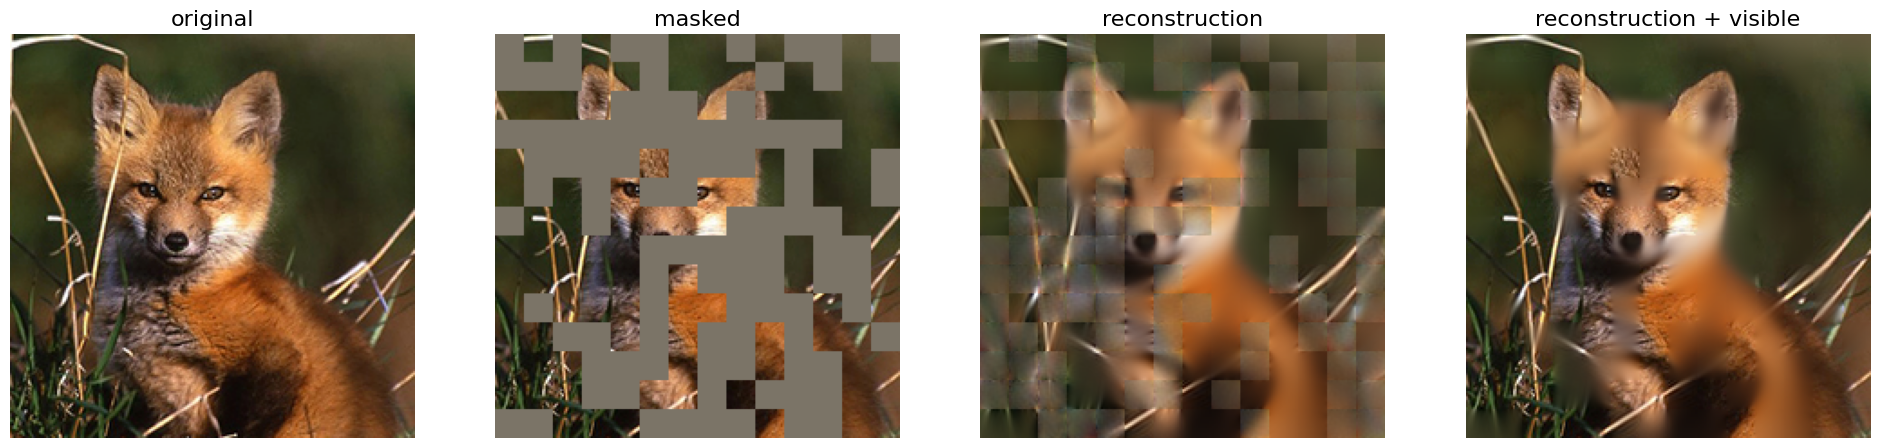

In [ ]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae, mask_ratio=0.5, masking_strategy='center')

### Load another pre-trained MAE model

In [ ]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large_ganloss.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with extra GAN loss:


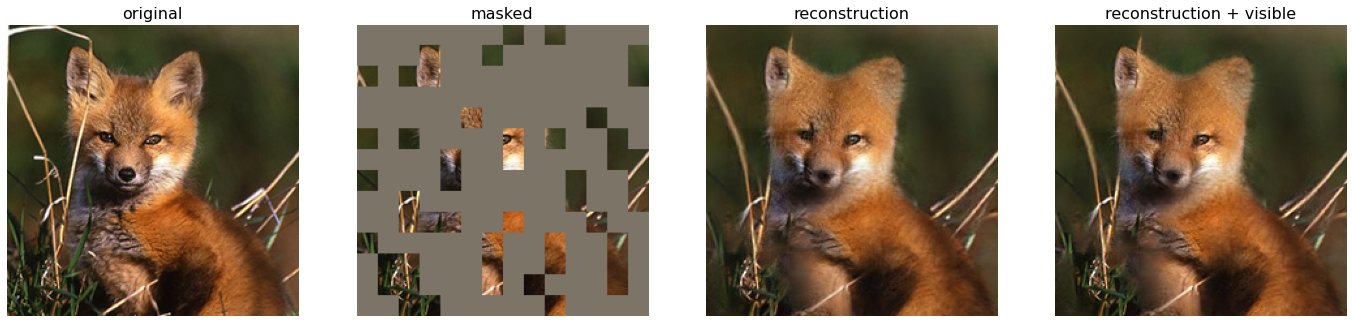

In [ ]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)